In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization

/home/cat/cv_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 19:09:36.383476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-05-08 19:09:37.849429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [3]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [4]:
BATCH_SIZE = 4
IMAGE_SIZE = 224

In [5]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=1,
    )
    return ds

In [6]:

train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)


train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [7]:
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

In [8]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

2024-05-08 19:09:40.441302: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a rec

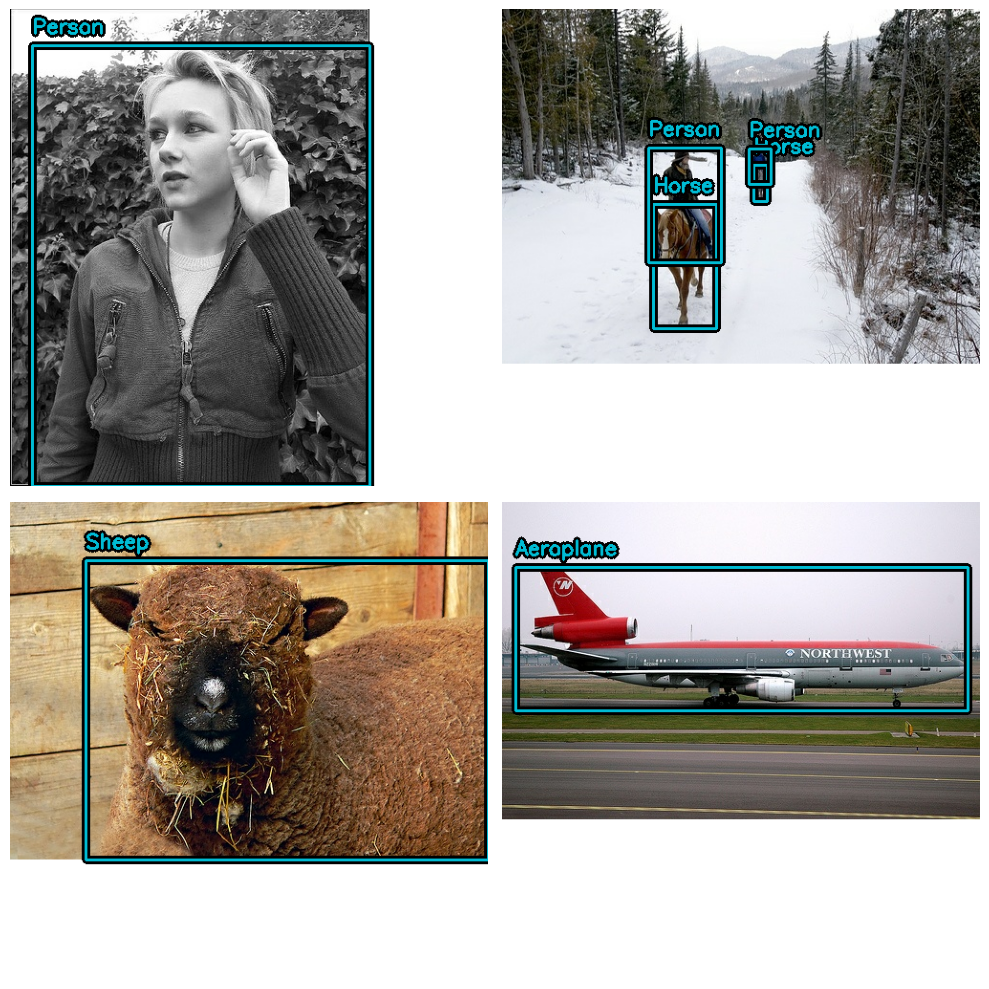

In [9]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


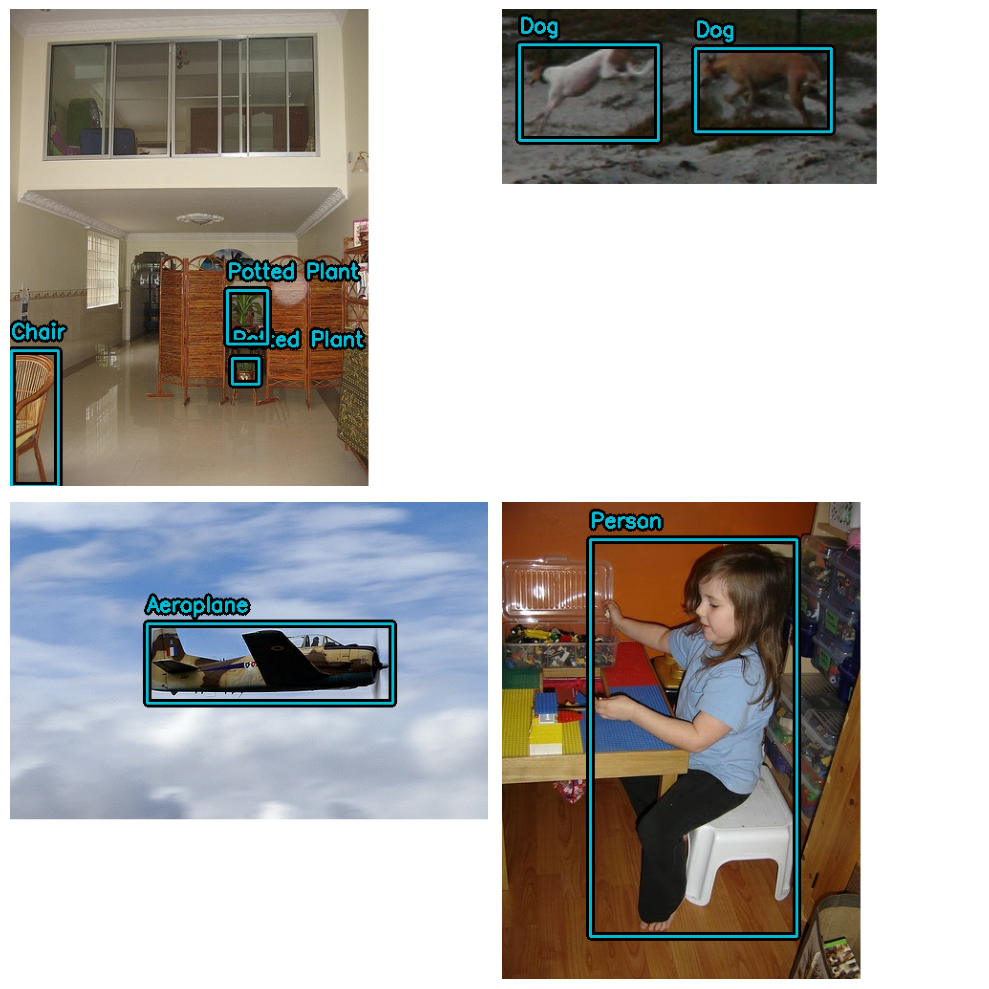

In [10]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

In [11]:
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE, IMAGE_SIZE, bounding_box_format="xywh", pad_to_aspect_ratio=True
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


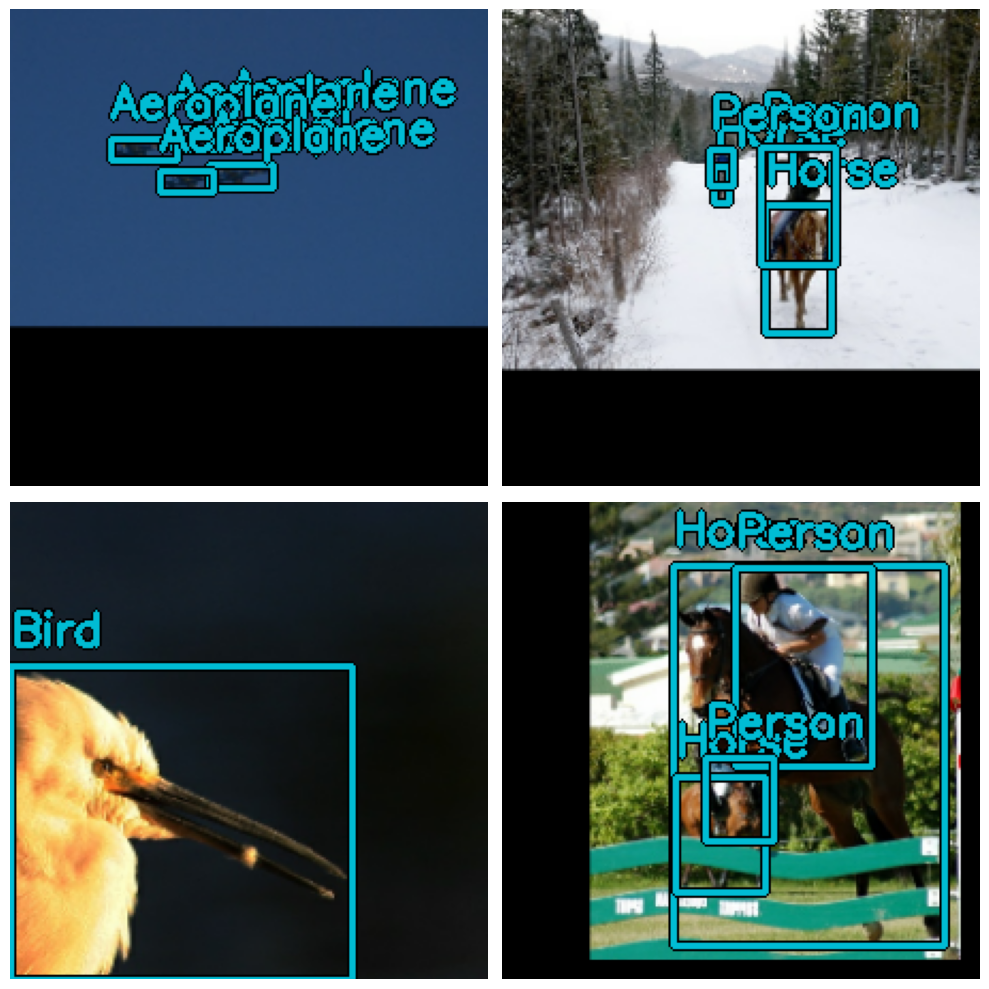

In [12]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(IMAGE_SIZE, IMAGE_SIZE), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(inference_resizing, num_parallel_calls=1).map(augmenter_fn, num_parallel_calls=1)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [13]:

eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=1)

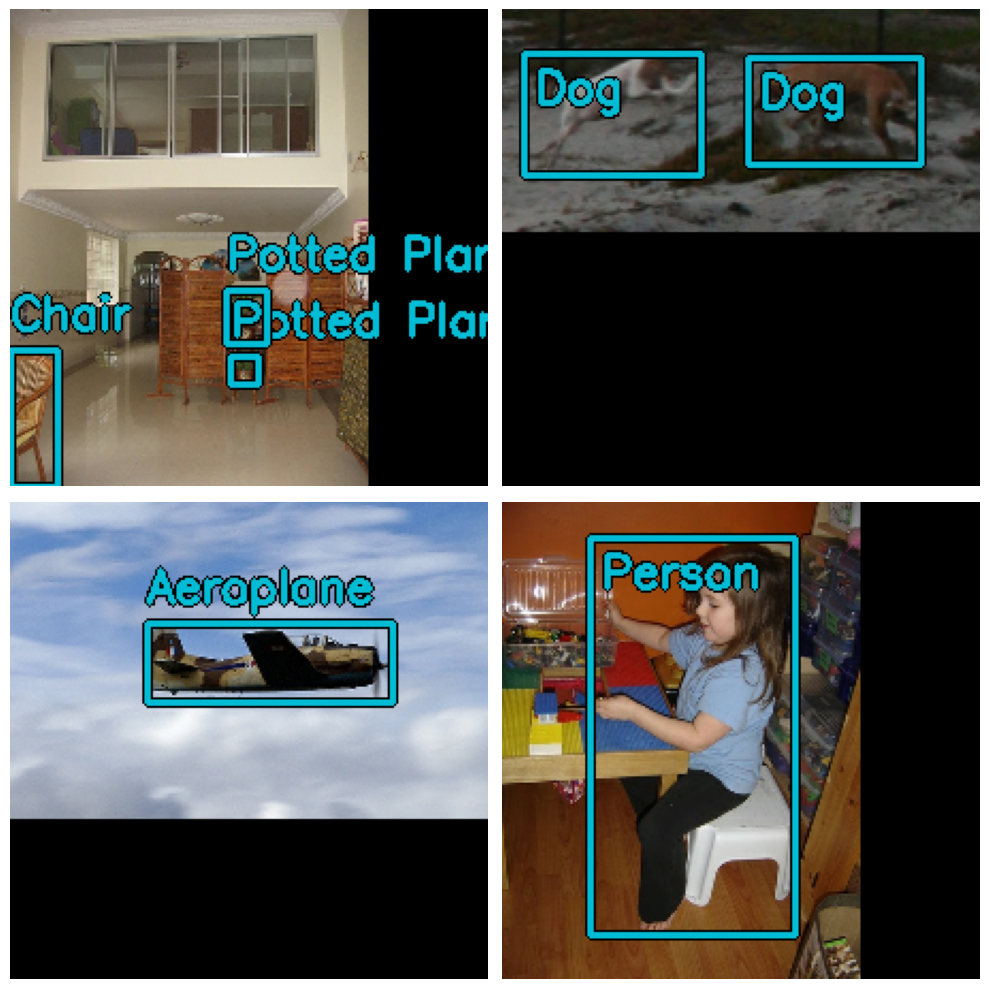

In [14]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [15]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=1)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=1)

train_ds = train_ds.prefetch(1)
eval_ds = eval_ds.prefetch(1)

In [16]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [17]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)


In [18]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring f

In [19]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [20]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring f

 1/20 ━━━━━━━━━━━━━━━━━━━━ 49:20 156s/step - loss: 1488.6721

2024-05-08 19:12:56.716215: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 1.67GiB (1793920632 bytes) by rematerialization; only reduced to 1.74GiB (1866920248 bytes), down from 2.29GiB (2456393112 bytes) originally
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


19/20 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 1110.5392

2024-05-08 19:13:29.748301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1095.5104

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step

2024-05-08 19:13:43.296544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step


2024-05-08 19:13:43.798335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (i

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av